In [1]:
%matplotlib inline

# Introduction

There are 3 relevant directories in `DataSciTest/`:
- `wx_data/`: Weather data files
- `yld_data/`: Yield data files
- `answers/`: Empty folder where you will place your answers to the questions on this exam.

---

More specifically, each file in `wx_data/` contains weather data records from 1-Jan-1985 to 31-Dec-2014 corresponding to a particular weather station from Nebraska, Iowa, Illinois, Indiana, or Ohio. Further, each line in the file contains 4 tab-separated records:
1. The date (YYYYMMDD format)
2. The maximum temperature for that day (in tenths of a degree Celsius)
3. The minimum temperature for that day (in tenths of a degree Celsius)
4. The amount of precipitation for that day (in tenths of a millimeter)

Note, missing values are indicated by the value `-9999.0`.

---

Finally, `yld_data/` contains only a single file - `US_corn_grain_yield.txt`, which stores a table of the total harvested corn grain yield in the US, measured in 1000s of megatons, for the years 1985 - 2014.

# Import Dependencies

We begin by importing the necessary libraries.

In [2]:
# System & OS
import os

# Data Analysis
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sns.set()
sns.set_style('whitegrid')      # background
plt.rc('figure', titlesize=24)  # figure title 
plt.rc('axes', titlesize=18)    # axes title
plt.rc('axes', labelsize=18)    # xy labels
plt.rc('xtick', labelsize=14)   # x tick labels
plt.rc('ytick', labelsize=14)   # y tick labels
plt.rc('legend', fontsize=14)   # legend

# Miscellaneous
from itertools import cycle, islice

# Preprocessing

Then, walk through the `wx_data/` directory - collecting, organizing, and recording the values to a master csv file.

In [3]:
wx_dir = '../wx_data'

with open(f'{wx_dir}/master_file.csv', 'w') as f:
    for root, dir, file in os.walk(wx_dir, topdown=True):
        for filepath in file:
            # Skip the filepath if it's the master file itself
            if os.path.join(root, filepath) == f'{wx_dir}/master_file.csv':
                continue
            df = pd.read_csv(os.path.join(root, filepath), sep='	', header=None, names=['date', 'max_temp', 'min_temp', 'percipitation'])
            for row in df.values:
                f.write(f'{filepath[:-4]}, {row[0]}, {row[1]}, {row[2]}, {row[3]}\n')
f.close()

Read back our results, and perform feature engineering + handle missing values.

In [4]:
df = pd.read_csv(f'{wx_dir}/master_file.csv', header=None, names=['station', 'date', 'max_temp', 'min_temp', 'percipitation'])
# Convert date column to datetime64
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
# Replace -9999.0 values with NaN
df.replace(-9999.0, np.nan, inplace=True)
# Display dataframe
df

,station,date,max_temp,min_temp,percipitation
0,USC00257715,1985-01-01,-83.0,-144.0,0.0
1,USC00257715,1985-01-02,0.0,-133.0,0.0
2,USC00257715,1985-01-03,22.0,-111.0,0.0
3,USC00257715,1985-01-04,61.0,-50.0,0.0
4,USC00257715,1985-01-05,78.0,-67.0,0.0
...,...,...,...,...,...
1729952,USC00259090,2010-08-27,289.0,150.0,0.0
1729953,USC00259090,2010-08-28,311.0,150.0,0.0
1729954,USC00259090,2010-08-29,322.0,161.0,0.0
1729955,USC00259090,2010-08-30,317.0,217.0,0.0


Now that the data is in good shape, we can proceed with our analysis.

# Problem 1
Write a program to calculate the number of days in which the maximum temperature and minimum temperature data are present, but the precipitation data is missing, for each weather data file in `wx_data/`. 

The program should create one line of output for each weather data file, with each line containing:
1. filename (e.g. USC00339312.txt)
2. number of days you have identified

Separate the columns by tabs, and write the output in ascending order by filename, before storing it in `answers/MissingPrcpData.out`.

In [5]:
# Filter rows based on given condition, group by station, and count rows
result = df[df.max_temp.notna() & df.min_temp.notna() & df.percipitation.isna()].groupby(['station']).size()
# Backfill missing stations with 0
for wx in df.groupby(['station']).size().index:
    if wx not in result.index:
        result = pd.concat([result, pd.Series({wx: 0})])
# Sort by station (filename)
result.sort_index(inplace=True)
# Display results
result

USC00110072    121
USC00110187      6
USC00110338     22
USC00111280     92
USC00111436    125
              ... 
USC00338552      8
USC00338769      7
USC00338822      9
USC00338830    201
USC00339312      0
Length: 167, dtype: int64

Export our results to a separate file. 

In [6]:
# Write results
with open('MissingPrcpData.out', 'w') as f:
    for i in range(len(result)):
        f.write(f'{result.index[i]}.txt {result.values[i]}\n')
f.close()

Let's try and visualize the scope of values we're dealing with using a boxplot.

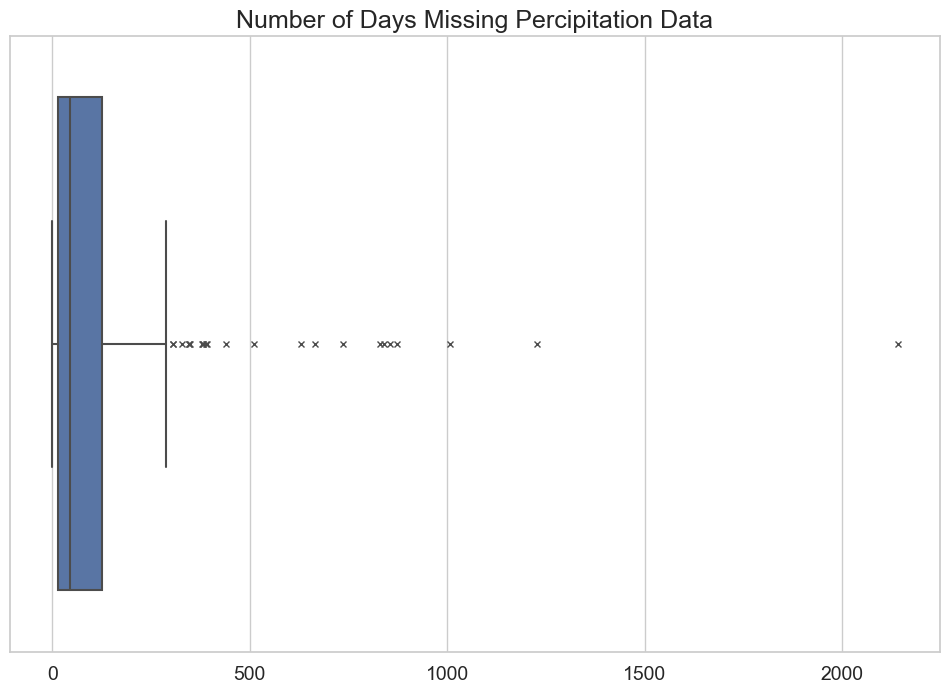

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x=result.values, flierprops={'marker': 'x'}, ax=ax).set(title='Number of Days Missing Percipitation Data')
plt.show()

The values appear to be heavily concentrated near 0, with several outliers on the order of $10^2$ - $10^3$. Naturally, we expect a histogram to reveal an underlying distribution resembling an exponential-logarithmic (EL) function. 

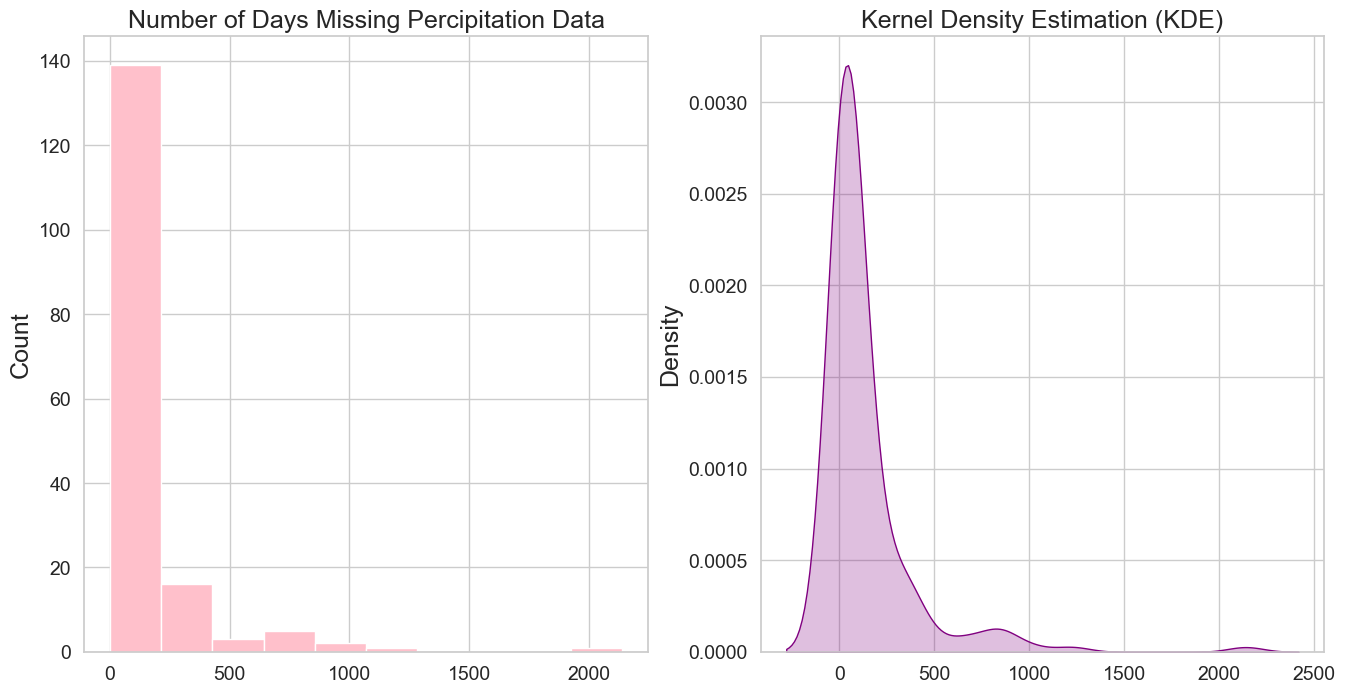

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8)) 
ax[0].hist(result.values, color='pink')
ax[0].set_title('Number of Days Missing Percipitation Data')
ax[0].set_ylabel('Count')
sns.kdeplot(result.values, color='purple', fill=True, ax=ax[1])
ax[1].set_title('Kernel Density Estimation (KDE)')
plt.show()

Indeed, our observations are consistent with expectations. 

These results imply that the data gathering at these weather stations is quite well-managed, at least with respect to daily percipitation data, since the majority of these facilities have <100 days of missing data over 30 years. The few outliers with hundreds (or thousands) of days missing could be explained by a variety of factors:
1. Station underwent reconstruction or closure
2. Undiscovered backend error
3. Human error

and so on... **Further work using geographic features to pinpoint root cause is recommended**.

# Problem 2
Write a program to calculate the following values for every year, and station, ignoring missing values:
- Average maximum temperature (in degrees Celsius)
- Average minimum temperature (in degrees Celsius)
- Total accumulated precipitation (in centimeters)

The program should create one line of output for each weather stations, with each line containing:
1. filename
2. year
3. average maximum temperature (to 2 decimal places) 
4. average minimum temperature (to 2 decimal places)
5. total accumulated precipitation (to 2 decimal places)

Note, if a value cannot be calculated, simply assign it a value of `-9999.00` in your output. Separate the columns by tabs, and order your results in ascending order by filename, before writing it to `answers/YearlyAverages.out`.

In [9]:
# Group by station and year, calculate aggregations, and round to 2 decimal places
result = df.groupby(['station', df.date.dt.year]).agg({'max_temp': 'mean',
                                                       'min_temp': 'mean',
                                                       'percipitation': 'sum'}).round(2)
# Reset station and year multi-level indices
result.reset_index(inplace=True)
# Rename columns
result.rename(columns={'date': 'year',
                       'max_temp': 'avg_max_temp',
                       'min_temp': 'avg_min_temp',
                       'percipitation': 'total_percipitation'}, 
                       inplace=True)
# Unit conversion: 1/10 C to C
result.avg_max_temp = round(result.avg_max_temp / 10, 2)
result.avg_min_temp = round(result.avg_min_temp / 10, 2)
# Unit conversion: 1/10 mm to cm
result.total_percipitation = round(result.total_percipitation / 100, 2)
# Replace NaN values
result.replace(np.nan, -9999.0, inplace=True)
# Sort by station (filename) and year
result.sort_values(by=['station', 'year'], inplace=True)
# Reset index
result.reset_index(drop=True, inplace=True)
# Display results
result

,station,year,avg_max_temp,avg_min_temp,total_percipitation
0,USC00110072,1985,15.34,4.33,78.01
1,USC00110072,1986,12.70,2.18,50.53
2,USC00110072,1987,17.76,6.33,79.36
3,USC00110072,1988,17.35,4.54,54.10
4,USC00110072,1989,15.65,3.98,79.37
...,...,...,...,...,...
4815,USC00339312,2010,16.17,4.34,103.40
4816,USC00339312,2011,16.31,5.05,136.07
4817,USC00339312,2012,17.80,5.16,91.08
4818,USC00339312,2013,15.47,4.02,109.90


Export our results to a separate file. 

In [10]:
# Write results
with open('YearlyAverages.out', 'w') as f:
    for i in range(len(result)):
        f.write(f'{result.station[i]}.txt   {result.year[i]}    {result.avg_max_temp[i]}    {result.avg_min_temp[i]}    {result.total_percipitation[i]}\n')
f.close()

A histogram or heatmap seems to be the most intuitive choice in this scenario for uncovering any underlying trends. To make our visualizations more useful, let's backfill any missing data along the 3 key metrics: `avg_max_temp`, `avg_min_temp`, `total_percipitation` (most logical approach given the time component).

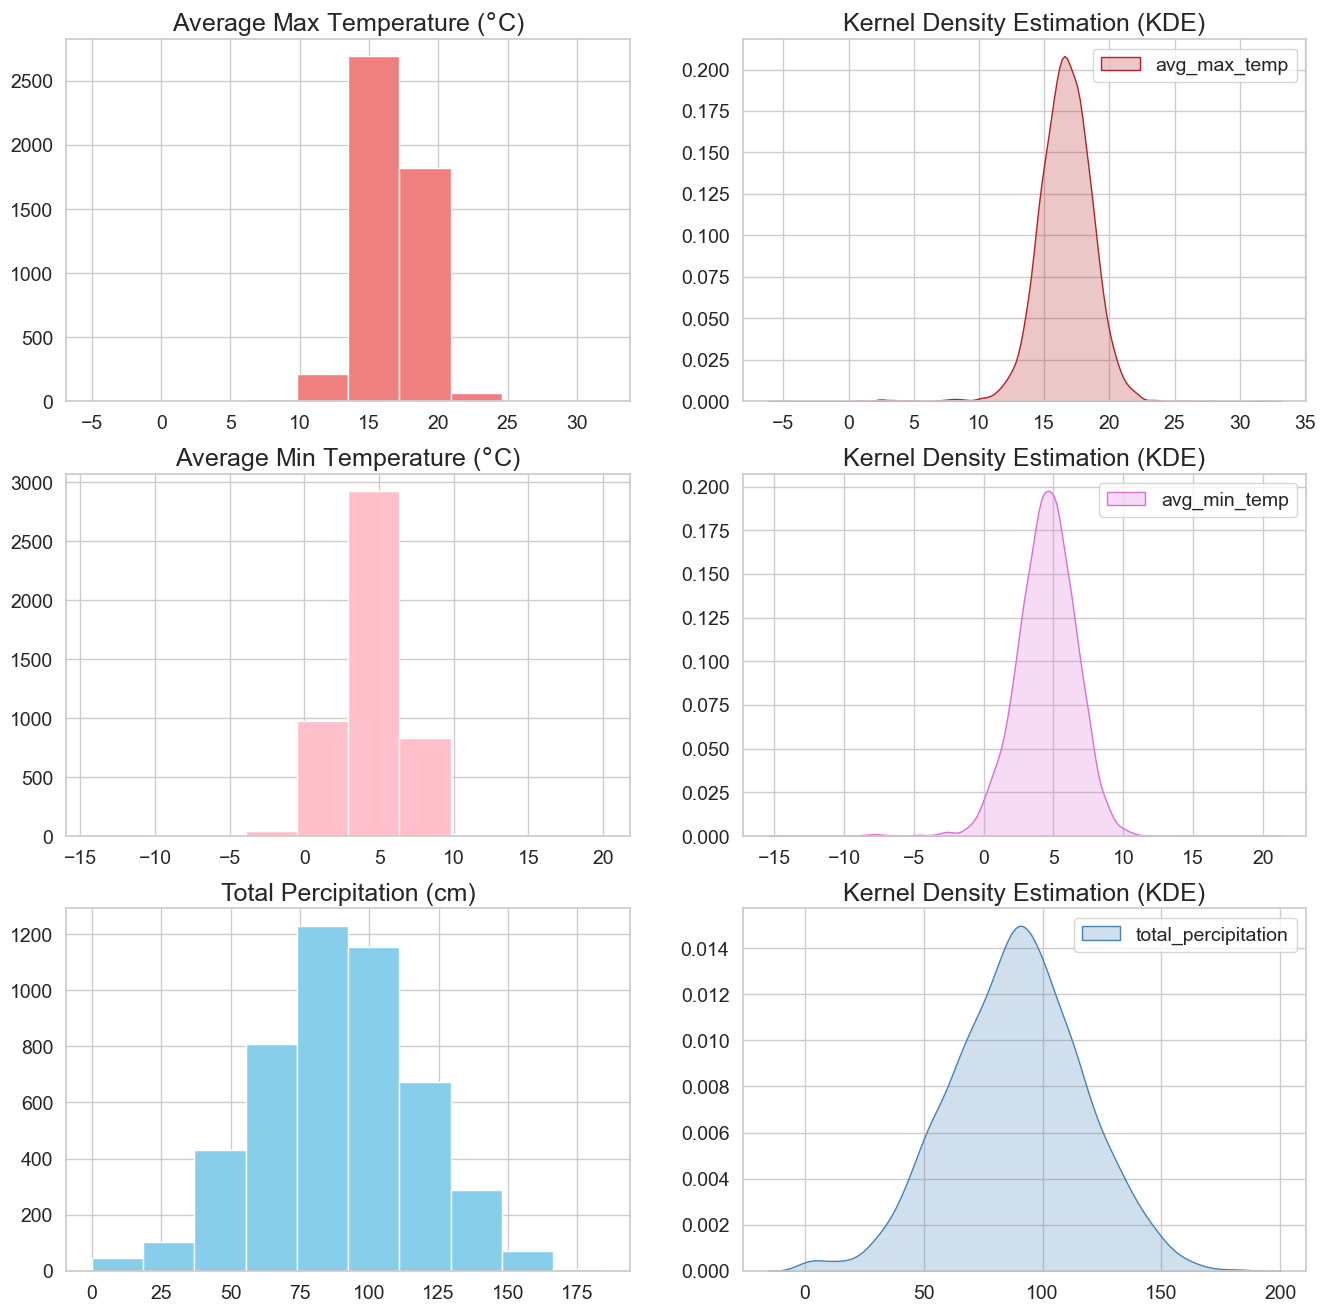

In [11]:
# Make a copy of our results
df_1 = result.copy()
# Backfill missing data
result.replace(-9999.0, np.nan, inplace=True)
result.fillna(method='bfill', inplace=True)

fig, ax = plt.subplots(3, 2, figsize=(16, 16)) 
metrics = ['avg_max_temp', 'avg_min_temp', 'total_percipitation']
for i in range(3):
    for j in range(2):
        if j == 0:
            if i == 0:
                ax[i][j].hist(result[metrics[i]], color='lightcoral')
                ax[i][j].set_title('Average Max Temperature ($\degree$C)')
            elif i == 1:
                ax[i][j].hist(result[metrics[i]], color='pink')
                ax[i][j].set_title('Average Min Temperature ($\degree$C)')
            else:
                ax[i][j].hist(result[metrics[i]], color='skyblue')
                ax[i][j].set_title('Total Percipitation (cm)')
        else:
            if i == 0:
                sns.kdeplot(result[metrics[i]], color='firebrick', fill=True, ax=ax[i][j])
                ax[i][j].set_title('Kernel Density Estimation (KDE)')
            elif i == 1:
                sns.kdeplot(result[metrics[i]], color='orchid', fill=True, ax=ax[i][j])
                ax[i][j].set_title('Kernel Density Estimation (KDE)')
            else:
                sns.kdeplot(result[metrics[i]], color='steelblue', fill=True, ax=ax[i][j])
                ax[i][j].set_title('Kernel Density Estimation (KDE)')
            ax[i][j].set_xlabel('')
            ax[i][j].set_ylabel('')
            ax[i][j].legend([metrics[i]])
plt.show()

Notice, all of the data is normal and well-behaved (always a pleasant surprise!) - with the mean average annual max temperature being about 10&deg;C higher than the mean average annual min temperature; consistent with real-world expectations. Further, the total percipitation appears to have a larger variance with respect to both temperature metrics, which again is consistent with expectations, since one would expect rainfall to vary more over time and location than temperature. 

Next, let's check if there are any trends over time in the data using a scatter plot, with each color representing a different station.

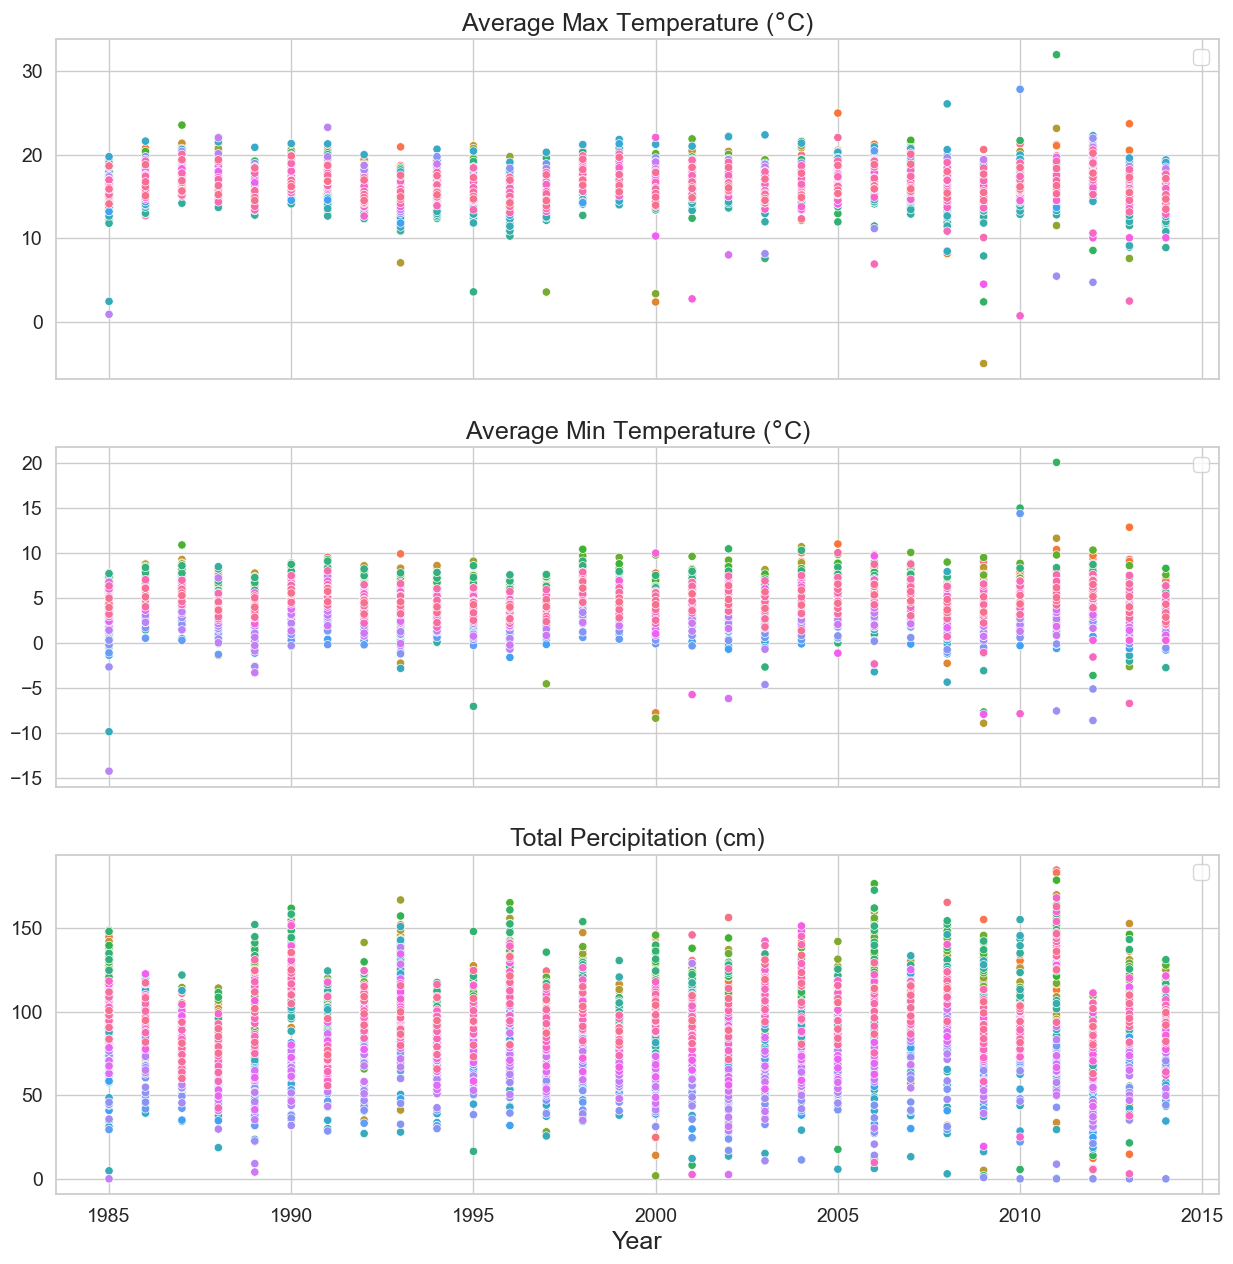

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15), sharex=True) 
metrics = ['avg_max_temp', 'avg_min_temp', 'total_percipitation']
for i in range(3):
    # sns.scatterplot(data=result, x='year', y=metrics[i], hue='station', ax=ax[i])
    sns.scatterplot(data=result, x='year', y=metrics[i], hue='station', ax=ax[i])
    if i == 0:
        ax[i].set_title('Average Max Temperature ($\degree$C)')
    elif i == 1:
        ax[i].set_title('Average Min Temperature ($\degree$C)')
    else:
        ax[i].set_title('Total Percipitation (cm)')
        ax[i].set_xlabel('Year')
    ax[i].set_ylabel('')
    ax[i].legend([])
plt.show()

At a glance, there doesn't seem to be any meaningful time-series information present, implying that the values are _fairly_ constant year-on-year. Since everything appears to be well-behaved, **no further work is recommended**.

# Problem 3
Using the results from Problem 2 as input, write a program that tabulates for each weather station, how often each year between 1985 - 2014 had:
- The highest average maximum temperature
- The highest average minimum temperature
- The highest total accumulated precipitation 

The resulting output should indicate how frequently a given year had the highest values in each category, for each weather station. In other words:
1. year
2. number of weather stations that recorded their highest annual average maximum temperature that year
3. number of weather stations that recorded their highest annual average minimum temperature that year
4. number of weather stations that recorded their highest total annual precipitation that year

Separate the columns by tabs, and sort in ascending order by year. Then, record your results to `answers/YearHistogram.out`. Also, create an additional histogram of your output, and save it as `answers/YearHistogram.png`.

In [13]:
# Group by station, and calculate expanding max for each metric
result = df_1.groupby(['station']).expanding().max().reset_index()
# Drop previous index
result.drop(columns='level_1', inplace=True)
# Filter by year of first occurence for each max value, group by year, and tabulate num occurences for each year
df_2 = pd.merge(df_1, result, on=['station', 'avg_max_temp'], suffixes=['', '_'])
df_3 = pd.merge(df_1, result, on=['station', 'avg_min_temp'], suffixes=['', '_'])
df_4 = pd.merge(df_1, result, on=['station', 'total_percipitation'], suffixes=['', '_'])
result = pd.concat([df_2[df_2['year'] == df_2['year_']].groupby(['year']).size(), df_3[df_3['year'] == df_3['year_']].groupby(['year']).size(), df_4[df_4['year'] == df_4['year_']].groupby(['year']).size()], axis=1).reset_index()
# Rename columns
result.rename(columns={'index': 'year',
                       0: 'highest_avg_max_temp',
                       1: 'highest_avg_min_temp',
                       2: 'highest_total_percipitation'}, inplace=True)
# Replace NaN values with 0
result.replace(np.nan, 0, inplace=True)
# Convert floats to ints
result = result.astype({'highest_avg_max_temp': 'int32',
                        'highest_avg_min_temp': 'int32',
                        'highest_total_percipitation': 'int32'})
# Sort by year
result.sort_values(by=['year'], inplace=True)
# Reset index
result.reset_index(drop=True, inplace=True)
# Display results
result

,year,highest_avg_max_temp,highest_avg_min_temp,highest_total_percipitation
0,1985,164,164,164
1,1986,149,157,68
2,1987,139,107,24
3,1988,28,6,3
4,1989,1,1,27
5,1990,35,51,91
6,1991,42,72,9
7,1992,4,7,11
8,1993,1,3,75
9,1994,4,8,0


Export our results to a separate file. 

In [14]:
# Write results
with open('YearHistogram.out', 'w') as f:
    for i in range(len(result)):
        f.write(f'{result.year[i]}  {result.highest_avg_max_temp[i]}    {result.highest_avg_min_temp[i]}    {result.highest_total_percipitation[i]}\n')
f.close()

Then, let's use a barplot to visualize how often each year recorded their highest values in any of the 3 metrics, across all available weather stations.

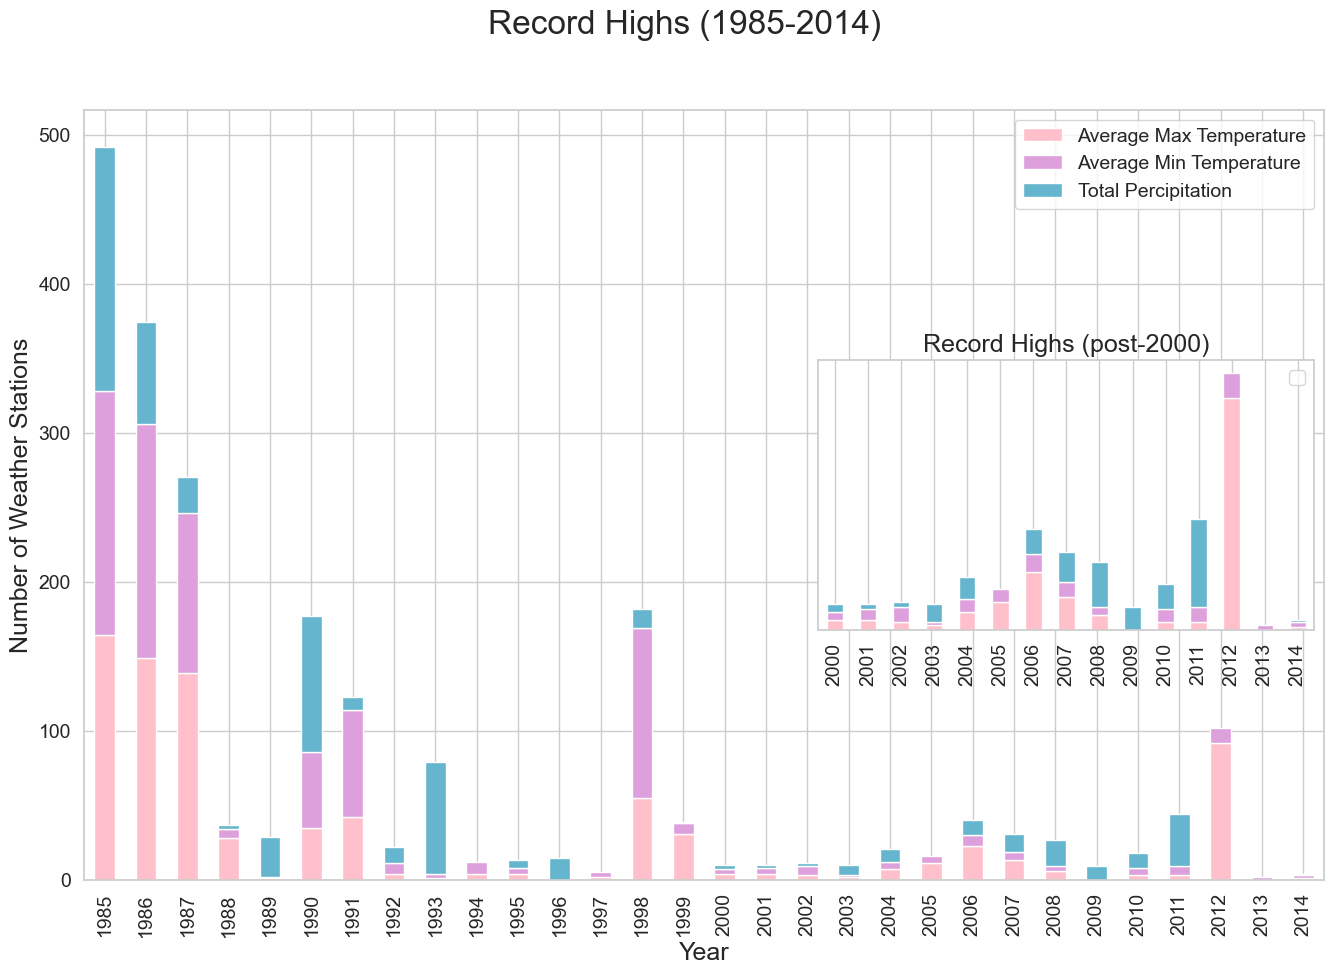

In [15]:
fig, ax = plt.subplots(figsize=(16, 10))
my_colors = list(islice(cycle(['pink', 'plum', 'c']), None, len(result)))
result.plot(kind='bar', stacked=True, x='year', color=my_colors, ax=ax)
fig.suptitle('Record Highs (1985-2014)')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Weather Stations')
ax.legend(['Average Max Temperature', 'Average Min Temperature', 'Total Percipitation'])

axins = inset_axes(ax, width='40%', height='35%', loc='center right')
result[result.year >= 2000].plot(kind='bar', stacked=True, x='year', color=my_colors, ax=axins)
axins.set_title('Record Highs (post-2000)')
axins.set_xlabel('')
axins.set_ylabel('')
axins.set_yticks([])
axins.legend([])

# Save figure
plt.savefig(f'YearHistogram.png', format='png')
plt.show()

As we expect, the years where data are first being recorded have seen the highest number of records broken, while as time goes on, record highs remain fairly rare, with the exception of a few noteworthy years, e.g. 1990 for total percipitation, 1998 for average min temperature, and 2012 for average max temperature.

However, if we only focus on the data since 2000, we notice a clear upward trend in weather stations recording record highs post-2000. This, in all likelihood, is probably an observation of the effects of climate change in the US.

Accordingly, let's inspect how the metrics themselves are distributed. We expect to see a high concentration near 0, since it's reasonable to assume record highs are fairly uncommon every year across weather stations.

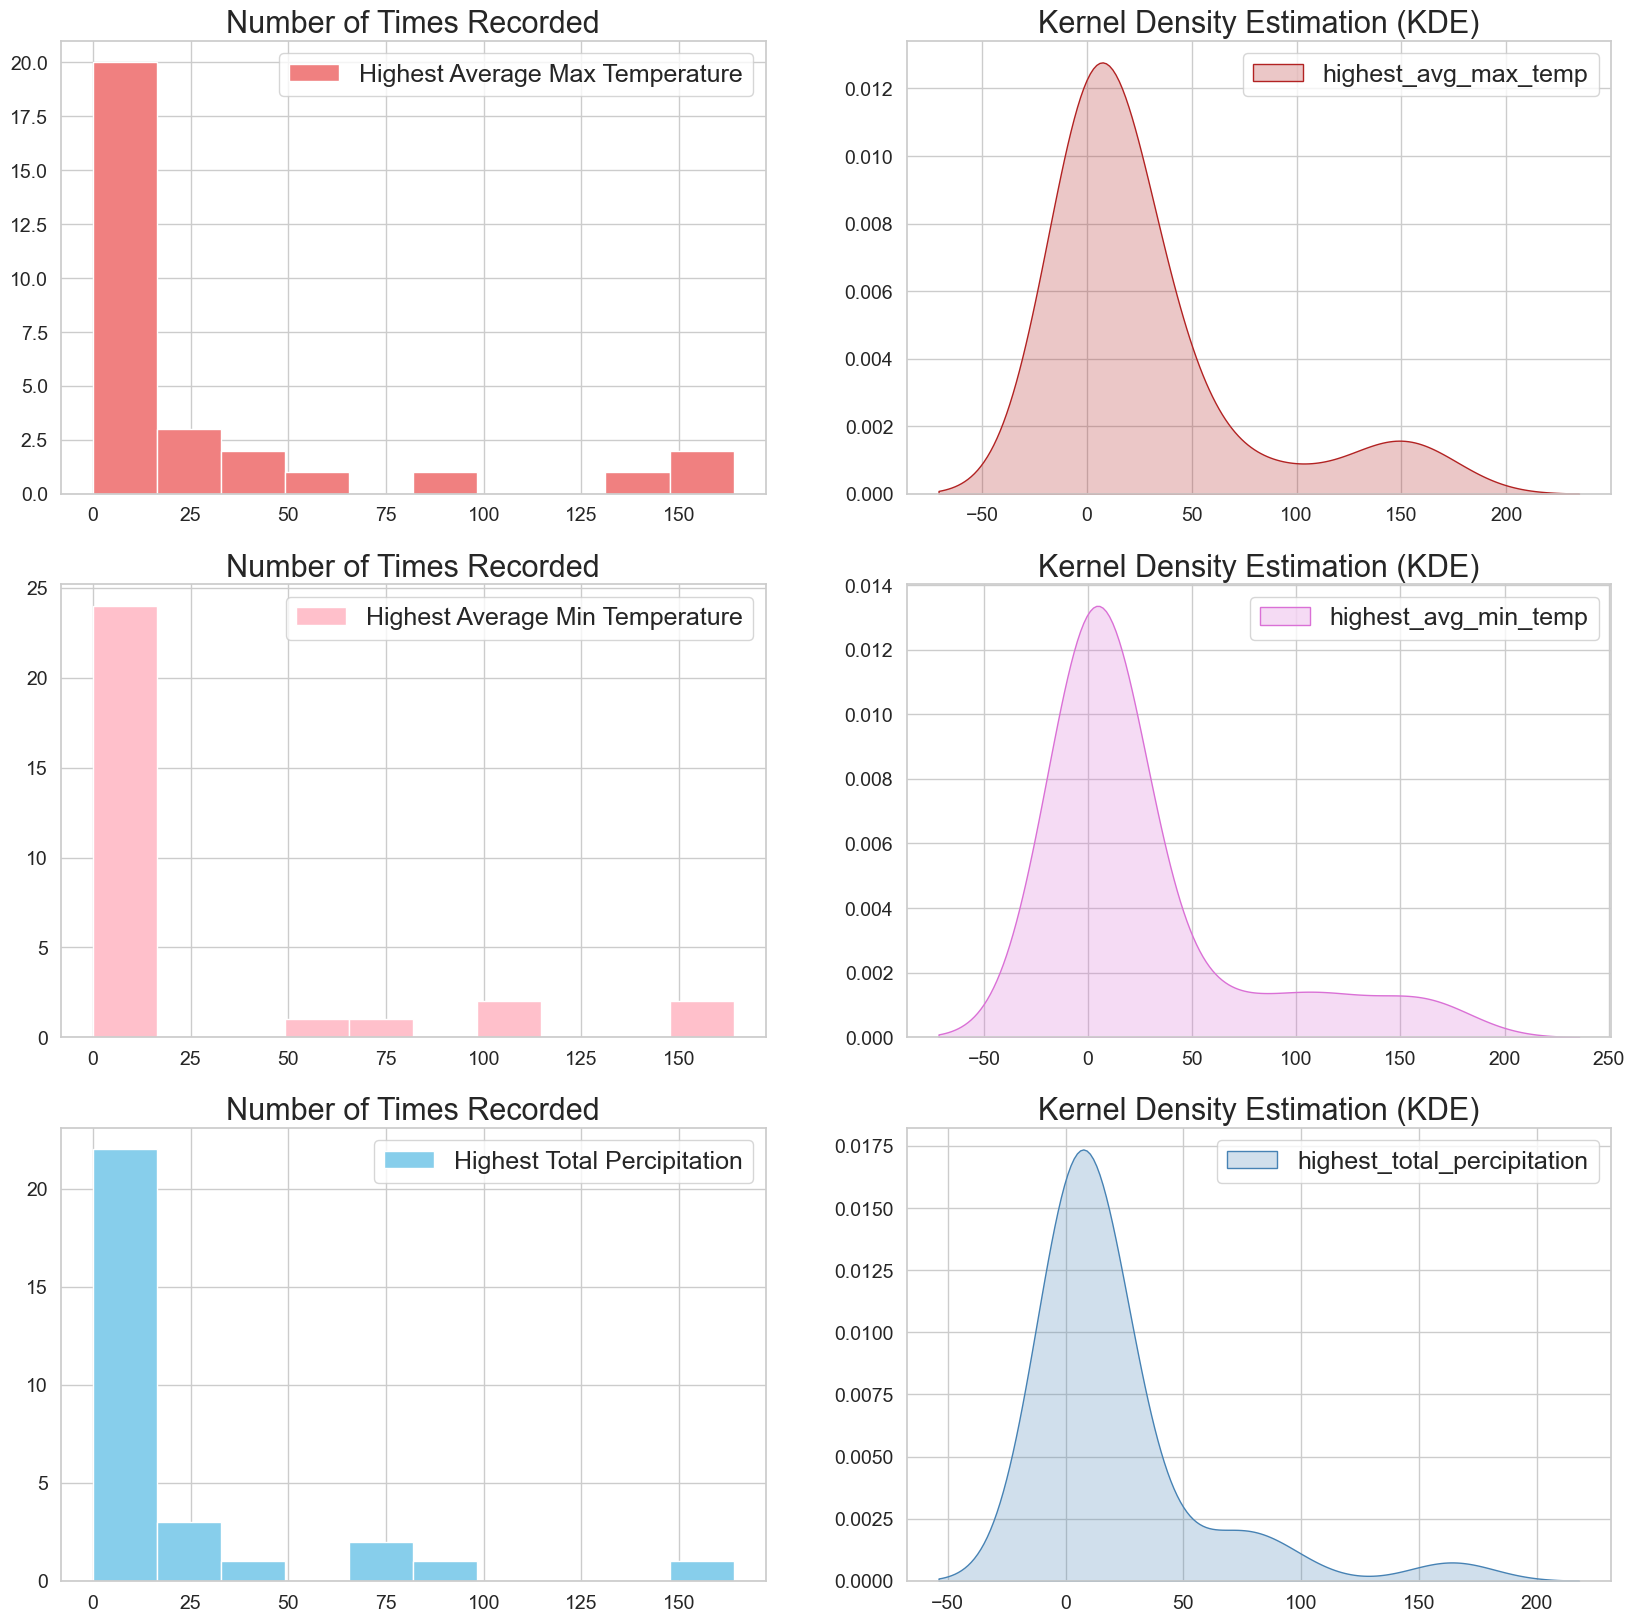

In [16]:
fig, ax = plt.subplots(3, 2, figsize=(20, 20)) 
metrics = ['highest_avg_max_temp', 'highest_avg_min_temp', 'highest_total_percipitation']
for i in range(3):
    for j in range(2):
        if j == 0:
            if i == 0:
                ax[i][j].hist(result[metrics[i]], color='lightcoral')
                ax[i][j].set_title('Number of Times Recorded', fontsize=22)
                ax[i][j].legend(['Highest Average Max Temperature'], fontsize=18)
            elif i == 1:
                ax[i][j].hist(result[metrics[i]], color='pink')
                ax[i][j].set_title('Number of Times Recorded', fontsize=22)
                ax[i][j].legend(['Highest Average Min Temperature'], fontsize=18)
            else:
                ax[i][j].hist(result[metrics[i]], color='skyblue')
                ax[i][j].set_title('Number of Times Recorded', fontsize=22)
                ax[i][j].legend(['Highest Total Percipitation'], fontsize=18)
        else:
            if i == 0:
                sns.kdeplot(result[metrics[i]], color='firebrick', fill=True, ax=ax[i][j])
                ax[i][j].set_title('Kernel Density Estimation (KDE)', fontsize=22)
            elif i == 1:
                sns.kdeplot(result[metrics[i]], color='orchid', fill=True, ax=ax[i][j])
                ax[i][j].set_title('Kernel Density Estimation (KDE)', fontsize=22)
            else:
                sns.kdeplot(result[metrics[i]], color='steelblue', fill=True, ax=ax[i][j])
                ax[i][j].set_title('Kernel Density Estimation (KDE)', fontsize=22)
            ax[i][j].set_xlabel('')
            ax[i][j].set_ylabel('')
            ax[i][j].legend([metrics[i]], fontsize=18)
plt.show()

As expected, nothing out of the ordinary! 

Though, the constant year-on-year increase in temperature and percipitation (especially post-2000) is a headache in the context of agriscience. **Further work using geographic features to identify if the increase is localized or uniform in space is recommended, with subsequent next steps hinging on our findings.**

# Problem 4
Using the results from Problem 2 as input, write a program to calculate the Pearson correlation between the (annual average maximum temperature, annual average minimum temperature, total annual precipitation) and the grain yield data from `yld_data/US_corn_grain_yield.txt`. 

Your output should contain:
1. filename (e.g. USC00339312.txt)
2. correlation coefficient between annual average maximum temperature and grain yield (round to 2 decimal places)
3. correlation coefficient between annual average minimum temperature and grain yield (round to 2 decimal places)
4. correlation coefficient between total annual precipitation and grain yield (round to 2 decimal places)

Separate the columns by tabs, and sort in ascending order by filename, before writing your results to `answers/Correlations.out`. 

In [17]:
# Read in the grain yield data
df_0 = pd.read_csv('../yld_data/US_corn_grain_yield.txt', sep='	', header=None, names=['year', 'yield'])
# Merge the two dataframes by year
df = pd.merge(df_0, df_1, on='year')
# Group by station, and calculate pearson correlation between yield and metrics
def pearson_r(df):
    yield_x_avg_max_temp , _ = pearsonr(df['yield'], df['avg_max_temp'])
    yield_x_avg_min_temp , _ = pearsonr(df['yield'], df['avg_min_temp'])
    yield_x_total_percp , _ = pearsonr(df['yield'], df['total_percipitation'])
    # Round to 2 decimals
    return round(yield_x_avg_max_temp, 2), round(yield_x_avg_min_temp, 2), round(yield_x_total_percp, 2)
result = df.groupby(['station']).apply(lambda x: pearson_r(x)).reset_index()
# Splice out relevant values
result['(yield, annual_avg_max_temp)'] = [result.iloc[i][0][0] for i in range(len(result))]
result['(yield, annual_avg_min_temp)'] = [result.iloc[i][0][1] for i in range(len(result))]
result['(yield, annual_total_percp)'] = [result.iloc[i][0][2] for i in range(len(result))]
result.drop(columns=0, inplace=True)
# Sort by station (filename)
result.sort_values(by=['station'], inplace=True)
# Reset index
result.reset_index(drop=True, inplace=True)
# Display results
result

,station,"(yield, annual_avg_max_temp)","(yield, annual_avg_min_temp)","(yield, annual_total_percp)"
0,USC00110072,-0.27,-0.29,0.21
1,USC00110187,0.28,0.11,0.02
2,USC00110338,-0.30,0.22,0.25
3,USC00111280,-0.25,-0.33,-0.13
4,USC00111436,0.10,0.01,0.09
...,...,...,...,...
162,USC00338552,-0.09,0.08,0.02
163,USC00338769,-0.26,-0.23,0.32
164,USC00338822,-0.37,-0.37,0.26
165,USC00338830,-0.27,0.29,0.18


Export our results to a separate file. 

In [18]:
# Write results
with open('Correlations.out', 'w') as f:
    for i in range(len(result)):
        f.write(f'{result.station[i]}.txt   {result["(yield, annual_avg_max_temp)"][i]}    {result["(yield, annual_avg_min_temp)"][i]}    {result["(yield, annual_total_percp)"][i]}\n')
f.close()

Check the descriptive statistics for each metric pair.

In [38]:
result.describe()

,"(yield, annual_avg_max_temp)","(yield, annual_avg_min_temp)","(yield, annual_total_percp)"
count,167.000000,167.000000,167.000000
mean,-0.141377,-0.098144,0.128862
std,0.207533,0.254785,0.204887
min,-0.580000,-0.710000,-0.650000
25%,-0.280000,-0.280000,0.010000
50%,-0.150000,-0.100000,0.160000
75%,0.000000,0.080000,0.270000
max,0.440000,0.480000,0.570000


Interesting, let's try visualizing the data before drawing any conclusions.

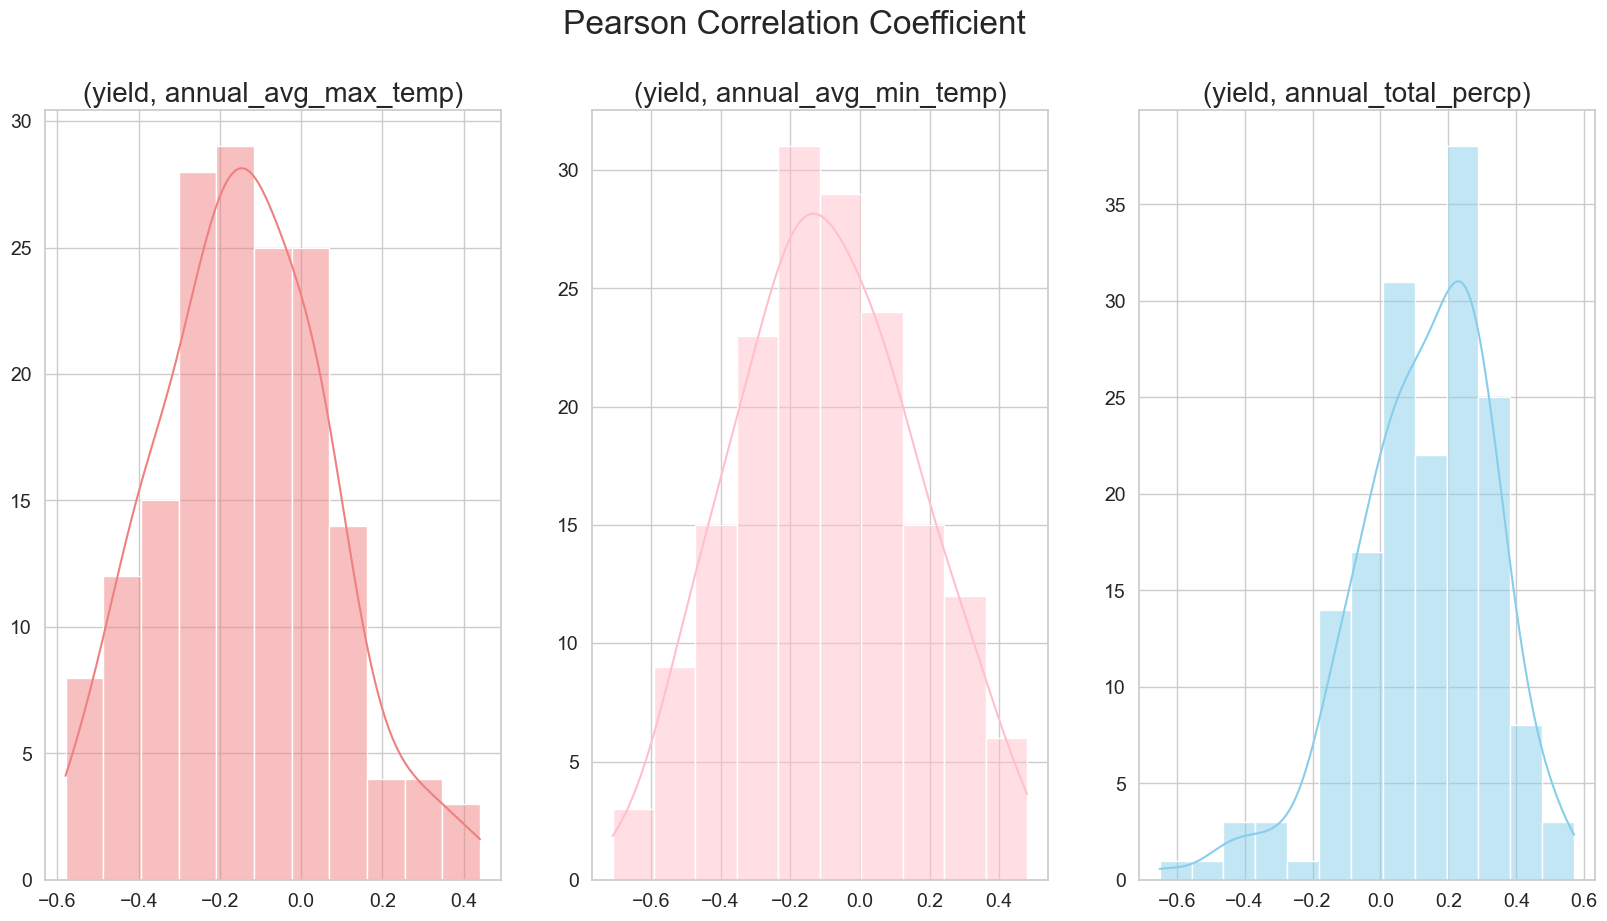

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10)) 
fig.suptitle('Pearson Correlation Coefficient', fontsize=24)
metrics = ['(yield, annual_avg_max_temp)', '(yield, annual_avg_min_temp)', '(yield, annual_total_percp)']
for i in range(3):
    if i == 0:
        sns.histplot(data=result[metrics[i]], color='lightcoral', kde=True, fill=True, ax=ax[i])
    elif i == 1:
        sns.histplot(data=result[metrics[i]], color='pink', kde=True, fill=True, ax=ax[i])
    else:
        sns.histplot(data=result[metrics[i]], color='skyblue', kde=True, fill=True, ax=ax[i])
    ax[i].set_title(metrics[i], fontsize=20)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
plt.show()

We find that a majority of weather stations have no correlation between any of the 3 metrics and the annual US grain yield, with only a select few having a fairly strong positive/negative correlation. This may be due to a variety of factors, such as certain locations having more influence on grain yield than others. **Hence, further work using descriptive features for each weather station (e.g. size, location, annual output, etc.) is needed to pinpoint the root cause.**

---

Email compressed archive of `DataSciTest/answers` to anuradha.swatantran@corteva.com and sangzi.liang@corteva.com.